In [43]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import argrelextrema

In [45]:
omp = 1
mpi = 4

# RT analysis of GaAs

This notebook contains the RT analysis of the photon echo mechanism for GaAs performed with Yambo.

## Analysis of a single transition

We study the behavior of a simulation in which there is a single $k$ point (using the nosym option).

We select a $k$-point with valence conduction gap of 1.5 eV, for this point the three conduction bands
are not degenerate and thus we can isolate the 4,5 transition. This situation should be described by
the physics of a standard TLS (with the only difference provided by the spin degeneration that brings
a factor 2 in the number of carriers)

In [46]:
simulations = {
    'k1_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_st_pi_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 95033,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_st_pi2_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_glek1.5_nosym',
        'field_int' : 23758,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    }
}

### Construction of the SAVE folder and FixSymm procedure

In [47]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

#Remove the contribution of the pseudo from the commutator
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

build SAVE for k1_nosym sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_st_pi_nosym sim with the -nosym option
SAVE folder already present in RT_singlek1.5_nosym. No operations performed.
 
build SAVE for k1_st_pi2_nosym sim with the -nosym option
Create folder RT_glek1.5_nosym
Executing command: cd NSCF/bnds_8-sampling_resonant_1.5eV.save; p2y -nosym
Create a symlink of /home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/NSCF/bnds_8-sampling_resonant_1.5eV.save/SAVE in RT_glek1.5_nosym
Executing command: cd RT_glek1.5_nosym;OMP_NUM_THREADS=1 yambo
 
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_glek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_glek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary.

The input are added to the simulations dict.

In [48]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 #fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [49]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [50]:
sel_sim = simulations
#sel_sim = dict((k,simulations[k]) for k in ['k1_st_hi_nosym','k1_st_pi2_nosym']) #k1_singletrans']) 

In [51]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') is not None:
        idd['bands'] = 'single-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    pars['ndb'] = results['dbs'][0]
    print('')

Initialize a parallel Yambo calculator with scheduler direct
run the computation for k1_nosym
Skip the run of bands_single-trans-eta_1e-05-field_eng_1.5-field_int_1000.0-sim_time_500
Job completed

run the computation for k1_st_pi_nosym
run 0 command: cd RT_singlek1.5_nosym; mpirun -np 4 yambo_rt -F bands_single-trans-eta_1e-05-field_eng_1.5-field_int_95033-sim_time_500.in -J bands_single-trans-eta_1e-05-field_eng_1.5-field_int_95033-sim_time_500 -C bands_single-trans-eta_1e-05-field_eng_1.5-field_int_95033-sim_time_500
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
Job completed

run the computation for k1_st_pi2_nosym
run 0 command: cd RT_glek1.5_nosym; mpirun -np 4 yambo_rt -F bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23758-sim_time_500.in -J bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23758-sim_time_500 -C bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23758-sim_time

In [54]:
sel_sim = dict((k,simulations[k]) for k in ['k1_st_pi_nosym','k1_st_pi2_nosym'])

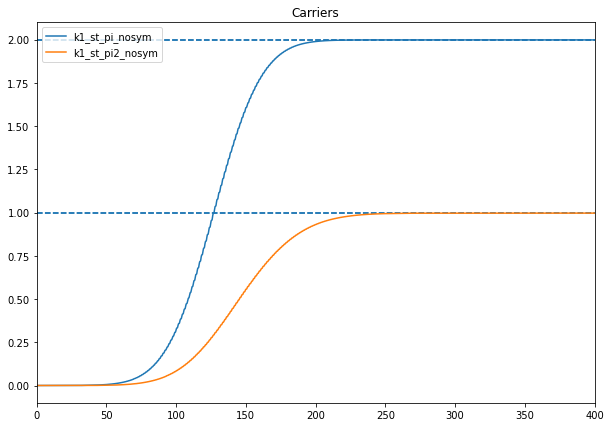

In [55]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    plt.hlines(1.,0,400,linestyles='--')
    plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

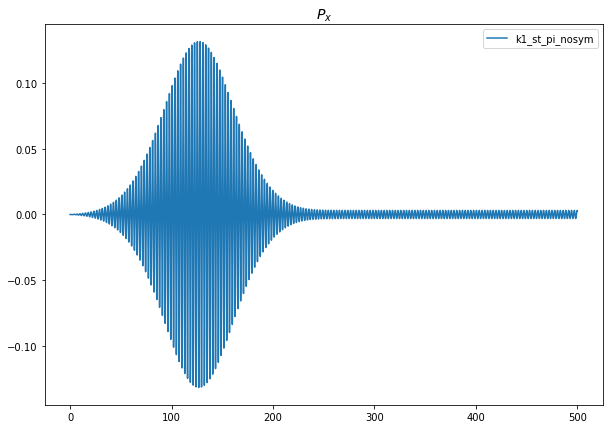

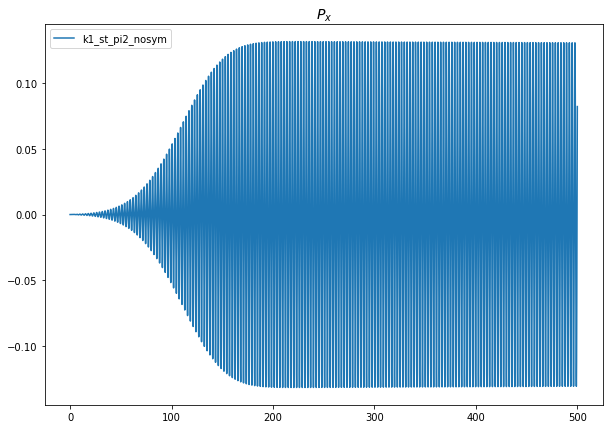

In [56]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

Calculation of theta

In [38]:
def eval_pulse_area(ndb,field_int,width,kpoint=0,bands=[0,1],component=0):
    """
    Compute the coupling frequency and the pulse are in function of the
    field intensity
    
    Args:
        ndb : name of the dipoles database
        field_int : field intensity in kW/cm^2
        width : the width of the field in fs
        kpoint : selected kpoint
        bands : bands of the transition
        component : cartesian component of the dipole
    """
    Z0 = U.vacuum_impedence
    dipoles = U.get_variable_from_db(ndb,'DIP_iR')
    dip = dipoles[kpoint][bands[0]][bands[1]][component]
    dip_mod = np.sqrt(dip[0]**2+dip[1]**2)

    field_int = field_int*1e3*1e4 #W/m^2
    field_amp = np.sqrt(Z0*field_int) #V/m
    field_amp = field_amp*U.Bohr_radius #V/a0 in atomic units
    coupling_frequency = dip_mod*field_amp*2*np.pi/U.Planck_ev_ps #THz
    
    theta = np.sqrt(2*np.pi)*width*coupling_frequency*1e-3
    print('coupling frequency (THz):',coupling_frequency)
    print('pulse area :',theta)
    return coupling_frequency,theta
    
def eval_field_intensity(ndb,theta,width,kpoint=0,bands=[0,1],component=0):
    """
    Compute the field intensity that produce the pulse are given as input
    
    Args:
        ndb : name of the dipoles database
        theta : pulse area
        width : the width of the field in fs
        kpoint : selected kpoint
        bands : bands of the transition
        component : cartesian component of the dipole
    """
    Z0 = U.vacuum_impedence
    dipoles = U.get_variable_from_db(ndb,'DIP_iR')
    dip = dipoles[kpoint][bands[0]][bands[1]][component]
    dip_mod = np.sqrt(dip[0]**2+dip[1]**2)
    
    coupling_frequency = theta/(np.sqrt(2*np.pi)*width*1e-3) #THz
    field_amp = coupling_frequency/(dip_mod*2*np.pi/U.Planck_ev_ps) #V/a0 in atomic units
    field_amp = field_amp/U.Bohr_radius #V/m
    field_int = field_amp**2/Z0 #W/m^2
    field_int = field_int*1e-3*1e-4 #kW/cm^2
    print('field intensity (kW/cm^2) :',field_int)
    return field_int

In [39]:
ndb_path = simulations['k1_nosym']['ndb']
width = 42.46609 # the field width in fs

In [40]:
field_int = 1000
eval_pulse_area(os.path.join(ndb_path,'ndb.dipoles'),field_int,width)

coupling frequency (THz): 3.027475063128577
pulse area : 0.32226473557579866


(3.027475063128577, 0.32226473557579866)

In [42]:
theta = np.pi
eval_field_intensity(os.path.join(ndb_path,'ndb.dipoles'),theta,width)

field intensity (kW/cm^2) : 95032.94241967653


95032.94241967653

In [ ]:
#####################################################################################

In [19]:
ndb_path = simulations['k1_nosym']['ndb']
dipoles = U.get_variable_from_db(os.path.join(ndb_path,'ndb.dipoles'),'DIP_iR')
# The structure of dipoles is [kpoint][band1][band2][component]

In [20]:
dip_x_cv = dipoles[0][0][1][0]
dip_mod = np.sqrt(dip_x_cv[0]**2+dip_x_cv[1]**2) #(atomic units)
dip_mod

19.401259949136858

In [21]:
Z0 = 376.730 #Ohm
field_int = 1000. # kW/cm^2
field_int = field_int*1e3*1e4 # W/m^2
field_amp = np.sqrt(Z0*field_int) #V/m
field_amp = field_amp*U.Bohr_radius #V/a0
coupling_frequency = dip_mod*field_amp*2*np.pi/U.Planck_ev_ps # THz
coupling_frequency

3.027473805465126

In [22]:
width = 42.46609 # the field width in fs
Theta = np.sqrt(2*np.pi)*width*coupling_frequency*1e-3
Theta

0.3222646017016722

In [23]:
Theta/1.541354

0.2090789018626949

In [24]:
def eval_pulse_area(ndb,field_int,width,kpoint=0,bands=[0,1],component=0):
    """
    Compute the coupling frequency and the pulse are in function of the
    field intensity
    
    Args:
        ndb : name of the dipoles database
        field_int : field intensity in kW/cm^2
        width : the width of the field in fs
        kpoint : selected kpoint
        bands : bands of the transition
        component : cartesian component of the dipole
    """
    Z0 = U.vacuum_impedence
    dipoles = U.get_variable_from_db(ndb,'DIP_iR')
    dip = dipoles[kpoint][bands[0]][bands[1]][component]
    dip_mod = np.sqrt(dip[0]**2+dip[1]**2)

    field_int = field_int*1e3*1e4 #W/m^2
    field_amp = np.sqrt(Z0*field_int) #V/m
    field_amp = field_amp*U.Bohr_radius #V/a0 in atomic units
    coupling_frequency = dip_mod*field_amp*2*np.pi/U.Planck_ev_ps #THz
    
    theta = np.sqrt(2*np.pi)*width*coupling_frequency*1e-3
    print('coupling frequency (THz):',coupling_frequency)
    print('pulse area :',theta)
    return coupling_frequency,theta
    
def eval_field_intensity(ndb,theta,width,kpoint=0,bands=[0,1],component=0):
    """
    Compute the field intensity that produce the pulse are given as input
    
    Args:
        ndb : name of the dipoles database
        theta : pulse area
        width : the width of the field in fs
        kpoint : selected kpoint
        bands : bands of the transition
        component : cartesian component of the dipole
    """
    Z0 = U.vacuum_impedence
    dipoles = U.get_variable_from_db(ndb,'DIP_iR')
    dip = dipoles[kpoint][bands[0]][bands[1]][component]
    dip_mod = np.sqrt(dip[0]**2+dip[1]**2)
    
    coupling_frequency = theta/(np.sqrt(2*np.pi)*width*1e-3) #THz
    field_amp = coupling_frequency/(dip_mod*2*np.pi/U.Planck_ev_ps) #V/a0 in atomic units
    field_amp = field_amp/U.Bohr_radius #V/m
    field_int = field_amp**2/Z0 #W/m^2
    field_int = field_int*1e-3*1e-4 #kW/cm^2
    print('field intensity (kW/cm^2) :',field_int)
    return field_int

In [18]:
field_int = 1000
width = 42.46609
eval_pulse_area(os.path.join(ndb_path,'ndb.dipoles'),field_int,width)

coupling frequency (THz): 3.027475063128577
pulse area : 0.32226473557579866


(3.027475063128577, 0.32226473557579866)

In [31]:
theta = np.pi*0.5

In [32]:
eval_field_intensity(os.path.join(ndb_path,'ndb.dipoles'),theta,width)

field intensity (kW/cm^2) : 23758.235604919133


23758.235604919133

In [ ]:
##############################################################################################

## Single $k$-point analysis

We perform various simulations with a single $k$-point, in particular
* simulation at $\Gamma$ with a resonant pump of 1.42 eV. In this case the three
valence bands are completely degenerate.
* simulation at $k_1$ a $k$-point with a valence-conduction gap of 1.5 eV. For
this point the valence bands have a small energy difference.

For all these simulations we choose $\eta=10^{-5}$ eV so that the damping induced
by $\eta$ is unrelevant on the time scale of some ps.

We build of the dictionary with the parameters of the various simulations.

In [55]:
simulations = {
    'gamma': {
        'source_dir' : 'NSCF/bnds_8-sampling_gamma.save',
        'run_dir' : 'RT_gamma', 
        'field_int' : 1e3,
        'field_eng' : 1.42,
        'sim_time'  : 2000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'k1': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 2000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01
    },
    'k1_singletrans': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 2000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_st_pi2': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5',
        'field_int' : 4e4,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_st_hi': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5',
        'field_int' : 2e6,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : False,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'sim_time'  : 2000,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_st_hi_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 1e6,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    },
    'k1_st_pi2_nosym': {
        'source_dir' : 'NSCF/bnds_8-sampling_resonant_1.5eV.save',
        'run_dir' : 'RT_singlek1.5_nosym',
        'field_int' : 2.3e4,
        'field_eng' : 1.5,
        'sim_time'  : 500,
        'field_pol' : 'linear',
        'eta'       : 1e-5,
        'no_sym'    : True,
        'obs_time'  : 0.01,
        'bands'     : [4,5]
    }
}

### Construction of the SAVE folder and FixSymm procedure

We build the SAVE folder, the FixSymm procedure is performed if needed.
The proper rt_run_dir key is added to the simulation dictionary

In [56]:
for sim,pars in simulations.items():
    source_dir = pars['source_dir']
    run_dir = pars['run_dir']
    pol = pars['field_pol']
    if not pars['no_sym']:
        pars['rt_run_dir'] = os.path.join(pars['run_dir'],'FixSymm')
        print('build SAVE and perform FixSymm for %s'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True)
        U.make_FixSymm(run_dir,polarization=pol,Efield1=[1.,0.,0.],Efield2=[0.,1.,0.])
    else:
        pars['rt_run_dir'] = pars['run_dir']
        print('build SAVE for %s sim with the -nosym option'%sim)
        U.build_SAVE(source_dir,run_dir,make_link=True,command='p2y -nosym')
    print(' ')

build SAVE and perform FixSymm for gamma
SAVE folder already present in RT_gamma. No operations performed.
FixSymm folder RT_gamma/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for k1
SAVE folder already present in RT_singlek1.5. No operations performed.
FixSymm folder RT_singlek1.5/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for k1_singletrans
SAVE folder already present in RT_singlek1.5. No operations performed.
FixSymm folder RT_singlek1.5/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for k1_st_pi2
SAVE folder already present in RT_singlek1.5. No operations performed.
FixSymm folder RT_singlek1.5/FixSymm already found. No operations performed.
 
build SAVE and perform FixSymm for k1_st_hi
SAVE folder already present in RT_singlek1.5. No operations performed.
FixSymm folder RT_singlek1.5/FixSymm already found. No operations performed.
 
build SAVE for k1_nosym sim with the -nosy

In [37]:
#simulations

Remove the contribution of the pseudo from the commutator

In [47]:
for pars in simulations.values():
    rt_run_dir = pars['rt_run_dir']
    db = 'ns.kb_pp_pwscf'
    src = os.path.join(rt_run_dir,'SAVE',db)
    dst = os.path.join(rt_run_dir,'SAVE',db+'_hide')
    command = 'mv %s %s'%(src,dst)
    print(command)
    os.system(command)

mv RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf RT_gamma/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf RT_singlek1.5/FixSymm/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide
mv RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf RT_singlek1.5_nosym/SAVE/ns.kb_pp_pwscf_hide


### Running of the simulations

We build the input object for each simulation. Some parameters are common for all the simulations
and are specified here, the others are taken from the dictionary

In [57]:
# Common parameters (eventually overwritten by the dictionary values)
field_width = 100 #fs set the width of the FWHM (it correspond to a field width of 42 fs)
bands = [2,5] # include the three valence bands (2-4) and the first conduction band (5)
scissor = 0.9548 # (eV) (taken from QE_Analysis it gives a direct gap of 1.42 eV)
time_step = 10 # as

In [58]:
for pars in simulations.values():
    if pars.get('bands') is not None:
        set_bands = pars.get('bands')
    else:
        set_bands = bands
    rt_input = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=pars['rt_run_dir'])
    rt_input.set_rt_field(int=pars['field_int'],width=field_width,polarization=pars['field_pol'],freq=pars['field_eng'])
    rt_input.set_rt_bands(bands=set_bands,scissor=scissor,damping_valence=pars['eta'],damping_conduction=pars['eta'])
    rt_input.set_rt_simulationTimes(sim_time=pars['sim_time'],time_units='fs',time_step=time_step)
    rt_input.set_rt_cpu(mpi)
    rt_input['variables']['DBsIOoff']='obs'  # do not write ndb.RT_observables on disk
    rt_input['variables']['IOtime'] = [[1.0,5.0,pars['obs_time']],'fs']
    if pars.get('Gauge') is not None:
        rt_input['variables']['Gauge'] = pars['Gauge']
    pars['input'] = rt_input

In [59]:
#simulations['k1_st_pi2_nosym']

Since the simulations have different run_dir we do not create a dataset but we directly use the run method of the 
calculator(s). 

The parsing of the results for each computation is added as a key in the simulations dictionary.

In [60]:
#sel_sim = simulations
sel_sim = dict((k,simulations[k]) for k in ['k1_st_hi_nosym','k1_st_pi2_nosym']) #k1_singletrans']) 

In [61]:
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',IO_time=20)

for sim,pars in sel_sim.items():
    print('run the computation for',sim)
    idd = dict((k,pars[k]) for k in ['field_int','field_eng','eta','sim_time'])
    if pars.get('Gauge') is not None:
        idd['gauge'] = pars['Gauge']
    if pars.get('bands') is not None:
        idd['bands'] = 'single-trans'
    name = D.name_from_id(idd)
    results = code.run(inputs=[pars['input']],names=[name],run_dir=pars['rt_run_dir'])
    pars['results'] = P.YamboParser(results['output'][0])
    print('')

Initialize a parallel Yambo calculator with scheduler direct
run the computation for k1_st_hi_nosym
Skip the run of bands_single-trans-eta_1e-05-field_eng_1.5-field_int_1000000.0-sim_time_500
Job completed

run the computation for k1_st_pi2_nosym
run 0 command: cd RT_singlek1.5_nosym; mpirun -np 4 yambo_rt -F bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23000.0-sim_time_500.in -J bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23000.0-sim_time_500 -C bands_single-trans-eta_1e-05-field_eng_1.5-field_int_23000.0-sim_time_500
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
Job completed



In [31]:
#sel_sim = dict((k,simulations[k]) for k in ['k1_singletrans','k1_st_pi2','k1_st_hi'])

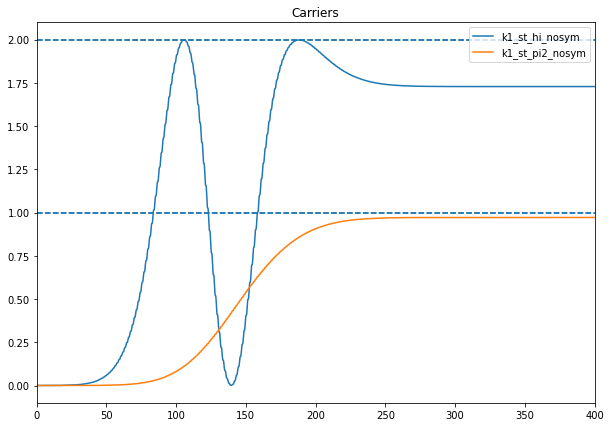

In [62]:
fig, ax = plt.subplots(figsize=(10, 7))
for study,val in sel_sim.items():
    carr = val['results']['carriers']
    time = carr['time']
    dne = carr['dne']
    ax.plot(time,dne,label=study)
    plt.hlines(1.,0,400,linestyles='--')
    plt.hlines(2,0,400,linestyles='--')
    ax.set_xlim(0,400)
    ax.set_title('Carriers')
    ax.legend(loc='best')

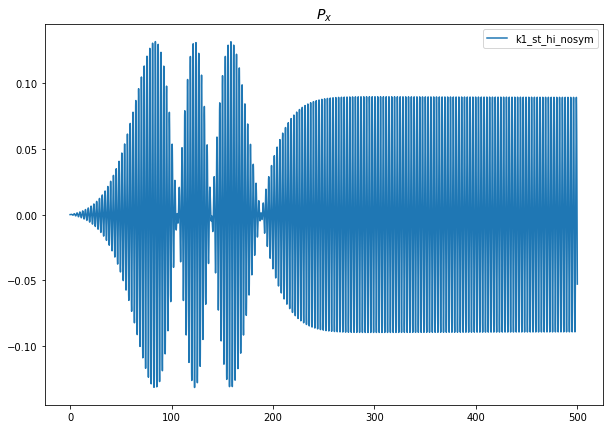

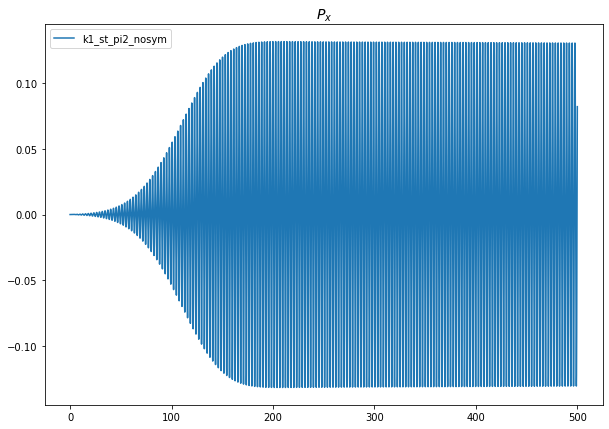

In [54]:
for study,val in sel_sim.items():
    fig, ax = plt.subplots(figsize=(10, 7))
    pol = val['results']['polarization']
    time = pol['time']
    px = pol['Pol_x']
    ax.plot(time,px,label=study)
    #ax.set_xlim(0,400)
    ax.set_title('$P_x$',size = 14)
    ax.legend(loc='best')
    plt.show()

In [ ]:
#############################################################################################

## Multi $k$ analysis

We build of the dictionary with the parameters of the various simulations.

In [4]:
simulations = {
    'k100': {
        'source_dir' : 'NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save',
        'run_dir' : 'RT_k100_kspan0.04', 
        'field_int' : 1e3,
        'field_eng' : 1.5,
        'field_pol' : 'linear',
        'eta'       : 1e-4,
        'no_sym'    : True,
        'obs_time'  : 0.01
    }    
}